In [3]:
# Sklearn으로 MNIST 데이터 가져오기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
# MNIST 배열 살펴보기
X, y = mnist["data"], mnist["target"]
X.shape

# 이미지가 70000개 있으며 각 이미지에 784개의 특성
# 이미지가 28 x 28
# 개개의 특성은 단순히 0 (흰색) ~ 255 (검은색)까지의 픽셀 강도를 나타냄

(70000, 784)

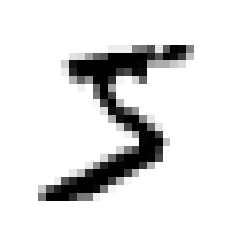

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

In [5]:
import numpy as np
print(y[0])
# Label이 문자열이므로 y를 정수로 변환
y = y.astype(np.uint8)

5


In [6]:
# MNIST 데이터셋은 이미 훈련 세트 (60000개) / 테스트 세트 (10000개) 로 나누어짐
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
# 이진 분류기 훈련
# 5-감지기 (5인가 아닌가)
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [7]:
# Sklearn의 SGDClassifier (확률적 경사 하강법, SGD) 분류기
# 큰 데이터셋을 효율적으로 처리하는 장점 -> 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문
# 온라인 학습에 잘 들어맞음
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True])

In [14]:
# 성능 측정
# 교차 검증을 사용한 정확도 측정
# 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassfier 모델 평가
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

NameError: name 'sgd_clf' is not defined

In [9]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [10]:
# 오차 행렬
# 클래스 A 샘플이 클래스 B로 잘못 분류된 횟수를 세는 것 (ex. 5를 3으로 잘못 분류 등)
from sklearn.model_selection import cross_val_predict

# cross_val_predict는 k-겹 교차 인증을 수행하지만 평가점수 대신 각 테스트 폴드에서 얻은 예측 반환
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# 행은 실제 클래스 / 열은 예측 클래스
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [12]:
# 완벽한 분류기
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [13]:
# 정밀도와 재현율
# Sklearn은 정밀도와 재현율을 포함해 분류기의 지표를 계산하는 여러 함수 제공
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [15]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [16]:
# 정밀도와 재현율을 F_1 점수라고 하는 하나의 숫자로 만들면 편리
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [17]:
# 정밀도/재현율 트레이드오프

# decision_function()을 통해 샘플 점수 얻기
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [18]:
# 임곗값이 0이므로 predict()와 같은 결과를 반환
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [19]:
# 임곗값을 0에서 8000으로 올리기
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [20]:
# 적절한 임곗값 정하기
# cross_val_predict()를 사용 (결정 점수를 반환하도록)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# 위에서 얻은 점수를 precision_recall_curve() 함수를 통해 가능한 모든 임곗값에 대해 정밀도와 재현율 계산 가능
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

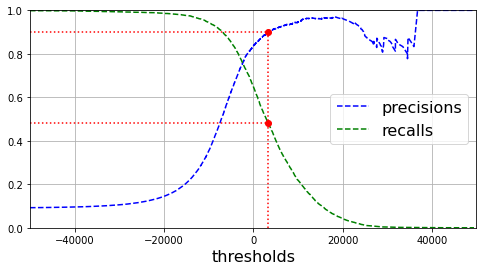

In [33]:
# matplotlib를 통해 임곗값의 함수로 정밀도와 재현율을 그릴 수 있음
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precisions")
    plt.plot(thresholds, recalls[:-1], "g--", label="recalls")
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("thresholds", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

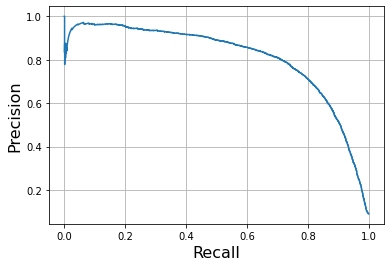

In [29]:
# 재현율에 대한 정밀도 곡선 그리기
def plot_precision_recall(precisions, recalls):
    plt.plot(recalls, precisions)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.grid(True)

plot_precision_recall(precisions, recalls)
plt.show()

In [35]:
# 정밀도 90%을 가지는 가장 낮은 임곗값 찾기
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

# 훈련 세트에 대한 예측을 만들기
# predict() 대신 위에서 구한 threshold를 활용해 코드를 실행
y_train_pred_90 = (y_scores >= threshold_90_precision)

# 정밀도와 재현율 확인
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


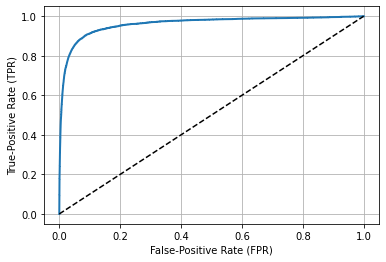

In [37]:
# ROC 곡선 그리기
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False-Positive Rate (FPR)')
    plt.ylabel('True-Positive Rate (TPR)')
    plt.grid(True)
    
plot_roc_curve(fpr, tpr)
plt.show()

In [38]:
# ROC의 AUC (Area under the curve) 측정
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

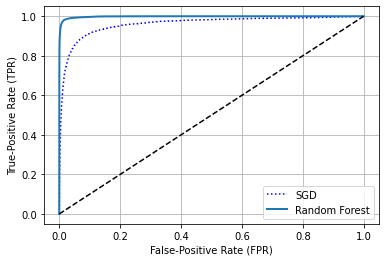

In [39]:
# RandomForestClassifier와 SGDClassifier의 ROC 곡선과 ROC AUC 점수 비교
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [46]:
# ROC AUC 점수 확인
print(roc_auc_score(y_train_5, y_scores_forest))

# 정밀도 / 재현율 계산
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))

0.9983436731328145
0.9905083315756169
0.8662608374838591


In [10]:
# 다중 분류
# SVM 분류기 테스트
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [12]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [49]:
# SVM에 OvR 사용 강제하기
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [50]:
# 분류기 갯수
len(ovr_clf.estimators_)

10

In [51]:
# SGDClassifier 사용
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [52]:
# SGD 예측 점수 확인
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [53]:
# SGDClassifier 교차 검증
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [18]:
# 입력 스케일 조정을 통해 정확도 올리기
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [19]:
# SGDClassifier 사용 (Scale)
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_scaled, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [55]:
# 에러 분석
# 오차 행렬 살펴보기
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

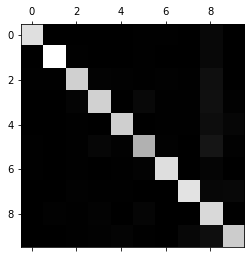

In [56]:
# matplotlib를 이용해 이미지로 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

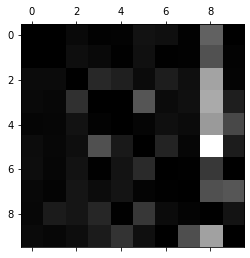

In [60]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [62]:
# 다중 레이블 분류
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) # 훈련 데이터중 7, 8, 9
y_train_odd = (y_train % 2 == 1) # 훈련 데이터중 홀수만
y_multilabel = np.c_[y_train_large, y_train_odd] # 2개의 타겟 레이블

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

In [63]:
# 모든 레이블에 대한 F_1 점수의 평균 계산
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [64]:
# 모든 레이블에 대한 F_1 점수의 평균 계산 (지지도)
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

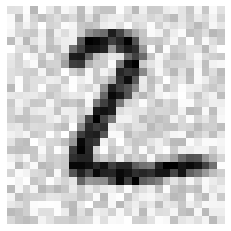

In [69]:
# 픽셀 강도에 잡음 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

plot_digit(X_test_mod[1])

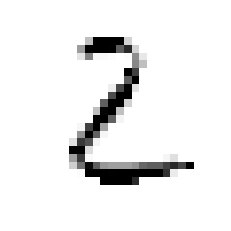

In [70]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

# 이미지를 깨끗하게 만들기
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[1]])
plot_digit(clean_digit)

In [20]:
print(X_train[1])

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  51. 159. 253. 159.  50.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  48. 238. 252. 252. 252. 237.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  54.
 227. 253. 252. 239. 233. 252.  57.   6.   0.   0.   0.   0.   0.   0.
   0. 